<a href="https://colab.research.google.com/github/kat-pierzchala/Data-mining---grupowanie/blob/master/Fairy_tales_g1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import nltk
import re
import random
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from tqdm import tqdm
from nltk import word_tokenize, pos_tag
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.chunk import ne_chunk
from nltk import pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
#from utils import plot_confusion_matrix

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

In [ ]:
%matplotlib inline

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
pip install textblob

In [ ]:
from textblob import TextBlob

In [ ]:
os.getcwd()

'/content'

In [ ]:
filepath = os.path.abspath('/content/fairy_tales.txt')

### Temat
Cel: Analiza sentymentu bajek i identyfikacja dominujących motywów.

- Rozpoznanie głównych tematów i archetypów postaci
- Porównanie tematyki bajek
- Czy bajki zawsze mają szczęśliwe zakończenia
- Które archetypy postaci występują najczęściej
-
###### Techniki:
1. Analiza sentymentu,
2. Word Cloud i analiza częstotliwości słów,
3. Analiza tematyczna,
4. Rozpoznawanie nazw własnych,
5. Analiza narracyjna,
6. Modelowanie tematów,
7. Porównanie stylów pisania.

### Wczytanie danych i czyszczenie

- Podział na bajki
- Dane treningowe i testowe
- Czyszczenie

### Rozdzielenie tekstu na bajki oraz wyszukanie tytułów

In [ ]:
with open(filepath, 'r', encoding="utf-8") as file:
    text = file.read()

stories = text.split('\n\n')

titles = []
for story in stories:
    lines = list(filter(None, story.strip().split('\n')))
    if not lines:
        continue
    first_line = lines[0].strip()
    match = re.match(r'^[A-Z][A-Za-z\s]{3,50}$', first_line)
    if match:
        titles.append(first_line)



for title in titles[:20]:
    print(title)

Lovely Ilonka
Lucky Luck
The Hairy Man
The Story of the Seven Simons
The Language of Beasts
The Boy Who Could Keep A Secret
The Prince And The Dragon
Little Wildrose
Tiidu The Piper
Paperarelloo
The Gifts Of The Magician
The Strong Prince
The Treasure Seeker
The Cottager And His Cat
The Prince Who Would Seek Immortality
The Three Robes
The Six Hungry Beasts
How The Beggar Boy Turned Into Count Piro
The Rogue And The Herdsman
Eisenkopf


In [ ]:
num_titles = len(titles)
print(f"Liczba bajek: {num_titles}")

Liczba bajek: 587


In [ ]:
stories_data = []

for i, title in enumerate(titles):
    for j, story in enumerate(stories):
        if story.strip().startswith(title):
            content = stories[j].strip()
            if i < len(titles) - 1:
                next_title = titles[i + 1]
                content = "\n".join(
                    [story.strip() for story in stories[j:] if not story.strip().startswith(next_title)]
                )
            stories_data.append({'title': title, 'content': content})
            break

In [ ]:
print(f"Liczba bajek w stories_data: {len(stories_data)}")

Liczba bajek w stories_data: 587


In [ ]:
for story in stories_data[:3]:
    print(f"Title: {story['title']}")
    print(f"Content: {story['content'][:300]}...")  # Pierwsze 300 znaków bajki
    print()

Title: Lovely Ilonka
Content: Lovely Ilonka
There was once a king's son who told his father that he wished to marry.
'No, no!' said the king; 'you must not be in such a hurry. Wait till you
have done some great deed. My father did not let me marry till I had won
the golden sword you see me wear.'
The prince was much disappointed...

Title: Lucky Luck
Content: Lucky Luck
Once upon a time there was a king who had an only son. When the lad was
about eighteen years old his father had to go to fight in a war against
a neighbouring country, and the king led his troops in person. He bade
his son act as Regent in his absence, but ordered him on no account to
mar...

Title: The Hairy Man
Content: The Hairy Man
Somewhere or other, but I don't know where, there lived a king who owned
two remarkably fine fields of rape, but every night two of the rape
heaps were burnt down in one of the fields. The king was extremely angry
at this, and sent out soldiers to catch whoever had set fire to the
rick...

In [ ]:
from sklearn.model_selection import train_test_split

# Wybieramy 200 losowych bajek
selected_stories = random.sample(stories_data, 200)
print(f"Liczba wybranych bajek: {len(selected_stories)}")

# Podział na zbiór treningowy i testowy (80% na trening, 20% na test)
train_data, test_data = train_test_split(selected_stories, test_size=0.2, random_state=42)

# Sprawdzamy rozmiary zbiorów
print(f"Liczba bajek w zbiorze treningowym: {len(train_data)}")
print(f"Liczba bajek w zbiorze testowym: {len(test_data)}")

Liczba wybranych bajek: 200
Liczba bajek w zbiorze treningowym: 160
Liczba bajek w zbiorze testowym: 40


In [ ]:
print("Przykłady z zestawu treningowego:\n")
for story in train_data[:3]:
    print(f"Title: {story['title']}")
    print(f"Content: {story['content'][:300]}...\n")
    print()

print("Przykłady z zestawu testowego:\n")
for story in test_data[:3]:
    print(f"Title: {story['title']}")
    print(f"Content: {story['content'][:300]}...")
    print()

Przykłady z zestawu treningowego:

Title: The back of the steed is a noble place
Content: The back of the steed is a noble place
     But the mule's dishonour, the ass disgrace!
The fine white asses, often thirteen hands high, sold by the Banu
Salib and other Badawi tribes, will fetch 100, and more. I rode
a little brute from Meccah to Jedda (42 miles) in one night and
it came in with me...


Title: THE SHADOW
Content: THE SHADOW
It is in the hot lands that the sun burns, sure enough! there the people
become quite a mahogany brown, ay, and in the HOTTEST lands they are
burnt to Negroes. But now it was only to the HOT lands that a learned
man had come from the cold; there he thought that he could run about
just as ...


Title: THE WINDMILL
Content: THE WINDMILL
A windmill stood upon the hill, proud to look at, and it was proud
too.
"I am not proud at all," it said, "but I am very much
enlightened without and within. I have sun and moon for my outward
use, and for inward use too; and int

### CZYSZCZENIE DANYCH

##### STOP WORDS

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Pobranie listy stop-wordów
stop_words = set(stopwords.words('english'))

In [ ]:
num_stop_words = len(stop_words)
print(f"Liczba stop_words: {num_stop_words}")

Liczba stop_words: 179


In [ ]:
stop_word_count = sum([1 for story in selected_stories for word in story['content'].split() if word in stop_words])
print(f'Liczba stop-wordów w zbiorze: {stop_word_count}')

Liczba stop-wordów w zbiorze: 74576463


##### CZYSZCZENIE

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

##### Tworzymy listy:
1. Lista tokenów
2. Lista z przetworzonym tekstem.
3. Lista z przetworzonym tekstem bez usuwania dużych liter - w celu wyczukania imion, nazw własnych.

#### TRENINGOWE

In [ ]:
def clean_text_all(text):
    # Usuwanie znaków innych niż litery i spacje
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenizacja
    tokens = word_tokenize(text.lower())  # lower dla pierwszej i drugiej funkcji
    tokens_2 = word_tokenize(text)  # oryginalna wielkość liter dla trzeciej funkcji
    # Usuwanie stopwords
    tokens_cleaned = [word for word in tokens if word not in stop_words]
    tokens_cleaned_2 = [word for word in tokens_2 if word not in stop_words]
    # Zwracanie różnych wersji przetwarzania
    return (
        tokens_cleaned,  # Lista tokenów (wersja lower)
        " ".join(tokens_cleaned) if tokens_cleaned else None,  # Tekst z tokenów (lower)
        " ".join(tokens_cleaned_2) if tokens_cleaned_2 else None  # Tekst z tokenów (oryginalna wielkość liter)
    )

# Trzy osobne listy
CL_data_tokens = []  # Tokeny
CL_data = []  # Tekst przetworzony (lower)
CL_data_names = []  # Tekst przetworzony (oryginalna wielkość liter)

for story in train_data:
    title = story['title']
    content = story['content']
    if len(content.strip()) > 3:
        tokens, cleaned_content, cleaned_content_2 = clean_text_all(content)
        if tokens and cleaned_content and cleaned_content_2:
            # Dodaj do listy tokenów
            CL_data_tokens.append({
                'title': title,
                'tokens': tokens
            })
            # Dodaj do listy tekstów (lower)
            CL_data.append({
                'title': title,
                'content': cleaned_content
            })
            # Dodaj do listy tekstów (oryginalna wielkość liter)
            CL_data_names.append({
                'title': title,
                'content': cleaned_content_2
            })

In [ ]:
CL_data_df = pd.DataFrame(CL_data)
CL_data_df.to_csv('CL_data.csv', index=False, encoding='utf-8')

CL_data_tokens_df = pd.DataFrame(CL_data_tokens)
CL_data_tokens_df.to_csv('CL_data_tokens.csv', index=False, encoding='utf-8')

CL_data_names_df = pd.DataFrame(CL_data_names)
CL_data_names_df.to_csv('CL_data_names.csv', index=False, encoding='utf-8')

In [ ]:
CL_data_df = pd.read_csv('CL_data.csv', encoding='utf-8')
CL_data = CL_data_df.to_dict(orient='records')

In [ ]:
CL_data_tokens_df = pd.read_csv('CL_data_tokens.csv', encoding='utf-8')
CL_data_tokens = CL_data_tokens_df.to_dict(orient='records')

In [ ]:
CL_data_names_df = pd.read_csv('CL_data_names.csv', encoding='utf-8')
CL_data_names = CL_data_names_df.to_dict(orient='records')

#### TESTOWE

In [ ]:
def clean_text_all_test(text):
    # Usuwanie znaków innych niż litery i spacje
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenizacja
    tokens = word_tokenize(text.lower())  # lower dla pierwszej i drugiej funkcji
    tokens_2 = word_tokenize(text)  # oryginalna wielkość liter dla trzeciej funkcji
    # Usuwanie stopwords
    tokens_cleaned = [word for word in tokens if word not in stop_words]
    tokens_cleaned_2 = [word for word in tokens_2 if word not in stop_words]
    # Zwracanie różnych wersji przetwarzania
    return (
        tokens_cleaned,  # Lista tokenów (wersja lower)
        " ".join(tokens_cleaned) if tokens_cleaned else None,  # Tekst z tokenów (lower)
        " ".join(tokens_cleaned_2) if tokens_cleaned_2 else None  # Tekst z tokenów (oryginalna wielkość liter)
    )

# Trzy osobne listy
test_CL_data_tokens = []  # Tokeny
test_CL_data = []  # Tekst przetworzony (lower)
test_CL_data_names = []  # Tekst przetworzony (oryginalna wielkość liter)

for story in test_data:
    title = story['title']
    content = story['content']
    if len(content.strip()) > 3:
        tokens, cleaned_content, cleaned_content_2 = clean_text_all_test(content)
        if tokens and cleaned_content and cleaned_content_2:
            # Dodaj do listy tokenów
            test_CL_data_tokens.append({
                'title': title,
                'tokens': tokens
            })
            # Dodaj do listy tekstów (lower)
            test_CL_data.append({
                'title': title,
                'content': cleaned_content
            })
            # Dodaj do listy tekstów (oryginalna wielkość liter)
            test_CL_data_names.append({
                'title': title,
                'content': cleaned_content_2
            })

In [ ]:
test_CL_data_df = pd.DataFrame(test_CL_data)
test_CL_data_df.to_csv('test_CL_data.csv', index=False, encoding='utf-8')

test_CL_data_tokens_df = pd.DataFrame(test_CL_data_tokens)
test_CL_data_tokens_df.to_csv('test_CL_data_tokens.csv', index=False, encoding='utf-8')

test_CL_data_names_df = pd.DataFrame(test_CL_data_names)
test_CL_data_names_df.to_csv('test_CL_data_names.csv', index=False, encoding='utf-8')

In [ ]:
test_CL_data_df = pd.read_csv('test_CL_data.csv', encoding='utf-8')
test_CL_data = test_CL_data_df.to_dict(orient='records')

test_CL_data_tokens_df = pd.read_csv('test_CL_data_tokens.csv', encoding='utf-8')
test_CL_data_tokens = test_CL_data_tokens_df.to_dict(orient='records')

test_CL_data_names_df = pd.read_csv('test_CL_data_names.csv', encoding='utf-8')
test_CL_data_names = test_CL_data_names_df.to_dict(orient='records')

#### LEMATYZACJA

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
for item in CL_data_tokens:
    item['tokens'] = [lemmatizer.lemmatize(token) for token in item['tokens']]

In [ ]:
for item in CL_data:
    item['content'] = " ".join([lemmatizer.lemmatize(word) for word in item['content'].split()])

In [ ]:
for item in CL_data_names:
    item['content'] = " ".join([lemmatizer.lemmatize(word) for word in item['content'].split()])

In [ ]:
print("Lematyzacja tokenów (pierwszy element):")
example_cleaned_story1 = CL_data_tokens[0]
print(f"Title: {example_cleaned_story1['title']}\n")
print(f"Content:{example_cleaned_story1['tokens'][:300]}...\n\n")

print("Lematyzacja tekstów (lower, pierwszy element):")
example_cleaned_story2 = CL_data[0]
print(f"Title: {example_cleaned_story2['title']}\n")
print(f"Content:{example_cleaned_story2['content'][:300]}...\n\n")

print("Lematyzacja tekstów (oryginalna wielkość liter, pierwszy element):")
example_cleaned_story3 = CL_data_names[0]
print(f"Title: {example_cleaned_story3['title']}\n")
print(f"Content:{example_cleaned_story3['content'][:300]}...")

Lematyzacja tokenów (pierwszy element):
Title: The Prince And The Dragon

Content:['[', "'", 'p', 'r', 'i', 'n', 'c', 'e', "'", ',', ' ', "'", 'd', 'r', 'a', 'g', 'o', 'n', "'", ',', ' ', "'", 'u', 'p', 'o', 'n', "'", ',', ' ', "'", 't', 'i', 'm', 'e', "'", ',', ' ', "'", 'l', 'i', 'v', 'e', 'd', "'", ',', ' ', "'", 'e', 'm', 'p', 'e', 'r', 'o', 'r', "'", ',', ' ', "'", 't', 'h', 'r', 'e', 'e', "'", ',', ' ', "'", 's', 'o', 'n', 's', "'", ',', ' ', "'", 'f', 'i', 'n', 'e', "'", ',', ' ', "'", 'y', 'o', 'u', 'n', 'g', "'", ',', ' ', "'", 'm', 'e', 'n', "'", ',', ' ', "'", 'f', 'o', 'n', 'd', "'", ',', ' ', "'", 'h', 'u', 'n', 't', 'i', 'n', 'g', "'", ',', ' ', "'", 's', 'c', 'a', 'r', 'c', 'e', 'l', 'y', "'", ',', ' ', "'", 'd', 'a', 'y', "'", ',', ' ', "'", 'p', 'a', 's', 's', 'e', 'd', "'", ',', ' ', "'", 'w', 'i', 't', 'h', 'o', 'u', 't', "'", ',', ' ', "'", 'o', 'n', 'e', "'", ',', ' ', "'", 'g', 'o', 'i', 'n', 'g', "'", ',', ' ', "'", 'l', 'o', 'o', 'k', "'", ',', ' ', "'", 'g', 'a

In [ ]:
CL_data_tokens_df = pd.DataFrame(CL_data_tokens)
CL_data_tokens_df.to_csv('CL_data_tokens_Lem.csv', index=False, encoding='utf-8')

In [ ]:
CL_data_df = pd.DataFrame(CL_data)
CL_data_df.to_csv('CL_data_Lem.csv', index=False, encoding='utf-8')

CL_data_names_df = pd.DataFrame(CL_data_names)
CL_data_names_df.to_csv('CL_data_names_Lem.csv', index=False, encoding='utf-8')

In [ ]:
CL_data_df = pd.read_csv('CL_data_Lem.csv', encoding='utf-8')
CL_data = CL_data_df.to_dict(orient='records')

In [ ]:
CL_data_tokens_df = pd.read_csv('CL_data_tokens_Lem.csv', encoding='utf-8')
CL_data_tokens = CL_data_tokens_df.to_dict(orient='records')

In [ ]:
CL_data_names_df = pd.read_csv('CL_data_names_Lem.csv', encoding='utf-8')
CL_data_names = CL_data_names_df.to_dict(orient='records')

In [ ]:
print(f"Liczba wybranych bajek: {len(CL_data)}")

Liczba wybranych bajek: 150


In [ ]:
for story in CL_data[:5]:
    print(f"Title: {story['title']}")
    print(f"Content: {story['content'][:200]}...")
    print()

Title: A Lost Paradise
Content: lost paradise middle great forest lived long time ago charcoalburner wife young handsome strong got married thought work would never fail bad times came grew poorer poorer nights went hungry bed becam...

Title: The Cruel Crane Outwitted
Content: cruel crane outwitted long ago bodisat born forest life genius tree standing near certain lotus pond time water used run short dry season certain pond large good many fish crane thought seeing fish mu...

Title: THE GOLDEN GOOSE
Content: golden goose man three sons youngest called dullhead sneered jeered snubbed every possible opportunity one day happened eldest son wished go forest cut wood started mother gave fine rich cake bottle w...

Title: LITTLE SNOW WHITE
Content: little snow white middle winter broad flakes snow falling around certain queen sat working window frame made fine black ebony looking upon snow pricked finger three drops blood fell upon gazed thought...

Title: ELEVENTH EVENING
Content: eleven

### 2. Wstępna eksploracja
- Częstotliwość występowania słów
- Bigramy
- Długości bajek i analiza rozkładu
- Motywy i tematy poruszane w najkrótszych i najdłuższych bajkach
- Aaliza TF-IDF

In [ ]:
all_words = [word for story in CL_data for word in story['content'].split()]
word_counts = Counter(all_words)

In [ ]:
unique_words = set(all_words)
print(f"Liczba unikalnych słów w zbiorze: {len(unique_words)}")

In [ ]:
all_words_tok = [word for story in CL_data_tokens for word in story['content'].split()]
word_counts2 = Counter(all_words_tok)

In [ ]:
unique_words_tok = set(all_words_tok)
print(f"Liczba unikalnych słów w zbiorze: {len(unique_words_tok)}")

Liczba unikalnych słów w zbiorze: 39082


##### 20 najczęściej występujących słów

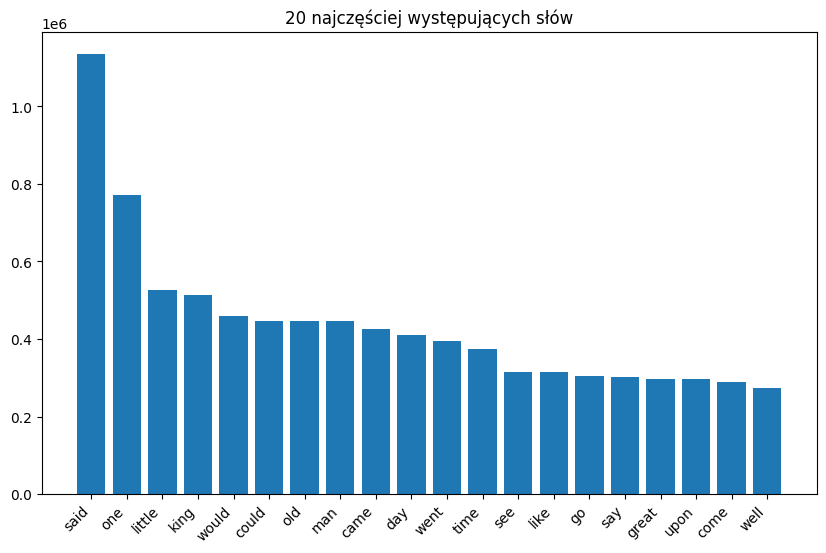

In [18]:
top_words = word_counts.most_common(20)

words, counts = zip(*top_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('20 najczęściej występujących słów')
plt.show()

##### Wizualizacja słownictwa charakterystycznego dla bajek - chmura słów

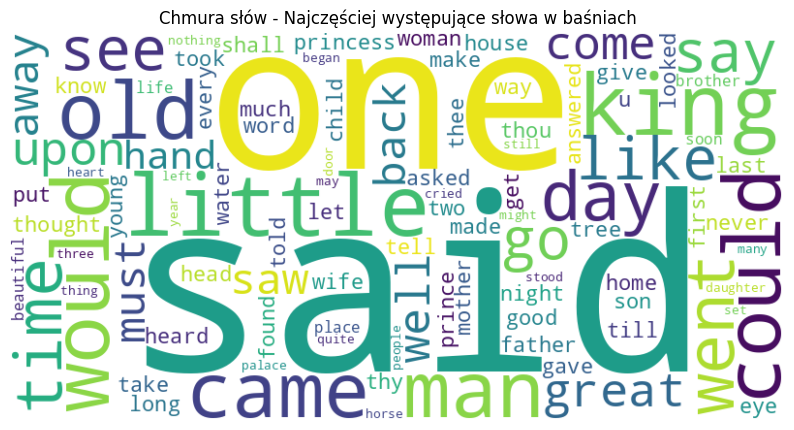

In [19]:
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(word_counts)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Chmura słów - Najczęściej występujące słowa w baśniach")
plt.show()

##### Interpretacja
Większość z tych słów wskazuje na klasyczny, narracyjny styl bajek, w którym mamy
- dialogi (said), podróże (went, go, came, away),
- postacie (king, man), w różnym wieku (little, old)
- odniesienia do czasu (day, upon, time).

W bajkach zwykle chodzi o przygody, podróże, moralne nauki, a także o interakcje między różnymi postaciami, co dobrze widać w występujących słowach.

##### BIGRAMY

In [20]:
# Funkcja do analizy n-gramów
def get_ngrams(texts, n=2):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform(texts)
    ngram_counts = ngrams.sum(axis=0).A1
    ngram_freq = dict(zip(vectorizer.get_feature_names_out(), ngram_counts))
    return ngram_freq

bigram_freq = get_ngrams([story['content'] for story in CL_data], n=2)

top_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)[:15]
print("Top 15 bigramów:")
for bigram, count in top_bigrams:
    print(f"{bigram}: {count}")

Top 15 bigramów:
old man: 111207
old woman: 83360
young man: 44614
said king: 30804
king son: 30769
said old: 28773
little girl: 26346
thou art: 23485
long time: 23374
thou hast: 23019
said little: 22108
little boy: 20554
went away: 18112
went home: 16324
said princess: 16038


#### Interpretacja
##### Postacie:
- Bigramy takie jak „old man”, „old woman”, „young man”, „little girl” i „little boy” wskazują na dominację klasycznych archetypów, które odgrywają centralną rolę w bajkach. Starsze postacie często pełnią role mędrców, mentorów lub antagonistów, podczas gdy młodsze postacie (mężczyźni, dziewczynki, chłopcy) są bohaterami, symbolizującymi niewinność, odwagę i przemiany.

#####  Dialogi i relacje:
- Bigramy takie jak „said old”, „said king”, „said little” wskazują na dużą rolę dialogów, w których starsze postacie lub postacie władzy (król) przekazują mądrości, rozkazy lub wskazówki, które kształtują fabułę. Mówiące dzieci i małe postacie („said little”) mogą symbolizować proste, ale ważne przesłania.

#####  Motywy fabularne:
- Bigramy takie jak „kings son”, „went away”, „went home” sugerują typowe motywy podróży, powrotów do domu, czy dążenia do odzyskania władzy lub sprawiedliwości. W kontekście bajek, które często opowiadają o młodych bohaterach, którzy muszą pokonać trudności lub odbyć podróż, te bigramy odzwierciedlają strukturę fabularną opartą na rozwoju postaci.

##### Język:
- Słowa jak „thou art” i „thou hast” wskazują na archaiczny język, który nadaje bajkom historyczny, magiczny lub fantastyczny ton, który jest charakterystyczny dla tradycyjnych opowieści. Pomaga to w budowaniu atmosfery i przenoszeniu czytelnika w odmienny świat.

##### Długości bajek

In [21]:
story_lengths = [len(story['content']) for story in CL_data]

In [22]:
story_word_counts = [len(story['content'].split()) for story in CL_data]

In [ ]:
avg_length = sum(story_word_counts) / len(story_word_counts)
min_length = min(story_word_counts)
max_length = max(story_word_counts)
print(f"Średnia długość bajek (w słowach): {avg_length}")
print(f"Minimalna długość bajek (w słowach): {min_length}")
print(f"Maksymalna długość bajek (w słowach): {max_length}")

Średnia długość bajek (w słowach): 533384.4933333333
Minimalna długość bajek (w słowach): 4835
Maksymalna długość bajek (w słowach): 1075659


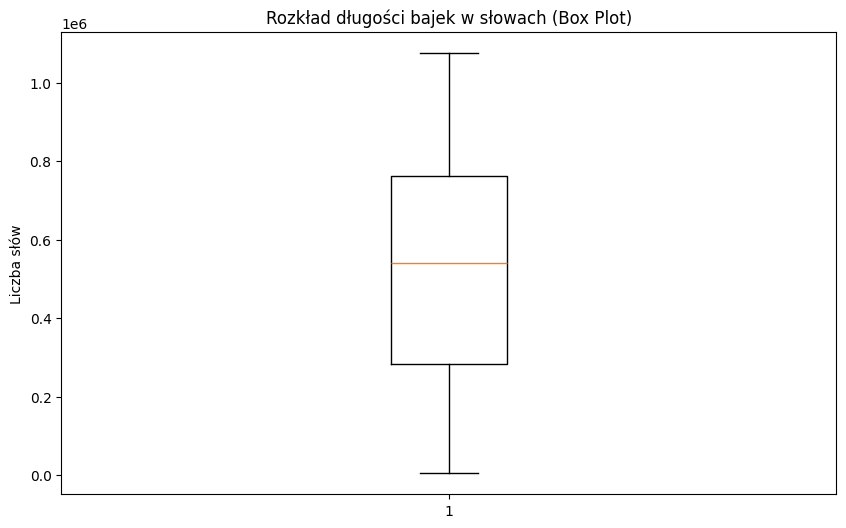

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(story_word_counts)
plt.title('Rozkład długości bajek w słowach (Box Plot)')
plt.ylabel('Liczba słów')
plt.show()

In [ ]:
longest_story = max(CL_data, key=lambda story: len(story['content'].split()))
shortest_story = min(CL_data, key=lambda story: len(story['content'].split()))

In [ ]:
print(f"Najdłuższa bajka: {longest_story['title']} - {len(longest_story['content'].split())} słów")
print(f"Najkrótsza bajka: {shortest_story['title']} - {len(shortest_story['content'].split())} słów")

Najdłuższa bajka: Lucky Luck - 1075659 słów
Najkrótsza bajka: THE TALE OF IVAN - 4835 słów


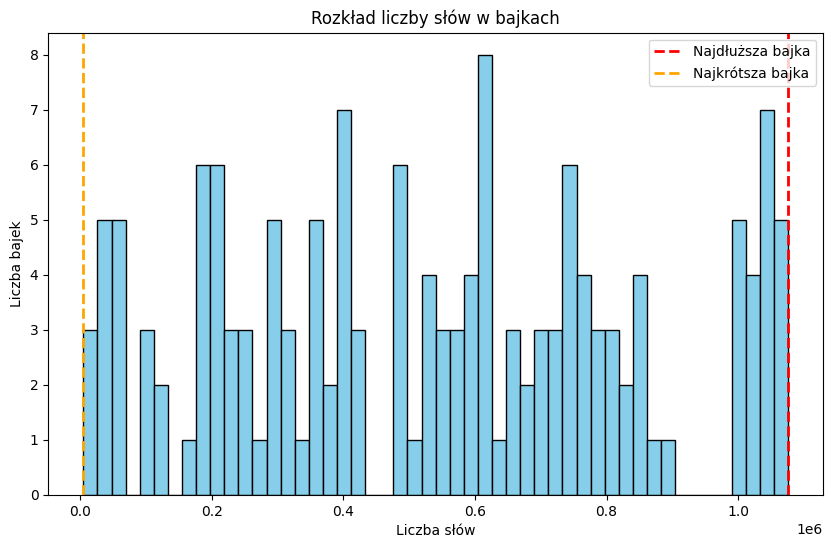

In [ ]:
# Wizualizacja długości bajek z wyróżnieniem najkrótszej i najdłuższej bajki
plt.figure(figsize=(10, 6))
plt.hist(story_word_counts, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=len(longest_story['content'].split()), color='red', linestyle='dashed', linewidth=2, label='Najdłuższa bajka')
plt.axvline(x=len(shortest_story['content'].split()), color='orange', linestyle='dashed', linewidth=2, label='Najkrótsza bajka')
plt.title('Rozkład liczby słów w bajkach')
plt.xlabel('Liczba słów')
plt.ylabel('Liczba bajek')
plt.legend()
plt.show()

##### Jakie motywy i tematy są poruszane w najkrótszych i najdłuższych bajkach?

In [ ]:
# Obliczanie 10% najkrótszych i najdłuższych bajek
shortest_FT = sorted(CL_data, key=lambda x: len(x['content']))[:int(len(CL_data) * 0.1)]
longest_FT = sorted(CL_data, key=lambda x: len(x['content']), reverse=True)[:int(len(CL_data) * 0.1)]

In [ ]:
print(f"Liczba najkrótszych bajek: {len(shortest_FT)}")
print(f"Liczba najdłuższych bajek: {len(longest_FT)}")

Liczba najkrótszych bajek: 15
Liczba najdłuższych bajek: 15


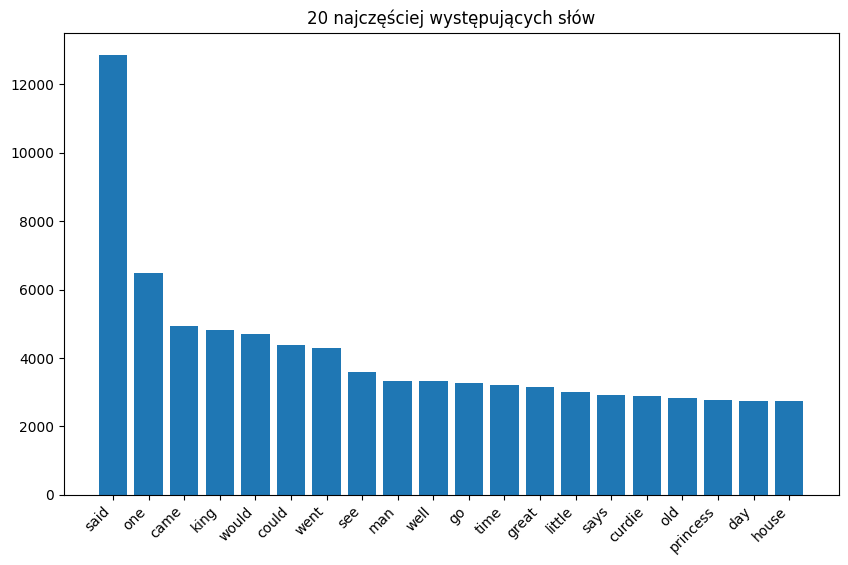

In [ ]:
all_words_s = [word for story in shortest_FT for word in story['content'].split()]
word_counts_s = Counter(all_words_s)
top_words_s = word_counts_s.most_common(20)

words, counts = zip(*top_words_s)
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('20 najczęściej występujących słów')
plt.show()

In [ ]:
bigram_freq_s = get_ngrams([story['content'] for story in shortest_FT], n=2)

top_bigrams_s = sorted(bigram_freq_s.items(), key=lambda x: x[1], reverse=True)[:15]
print("Top 15 bigramów:")
for bigram, count in top_bigrams_s:
    print(f"{bigram}: {count}")

Top 15 bigramów:
old man: 720
kings son: 698
said king: 499
andrew coffey: 479
said curdie: 356
son king: 337
grey beggarman: 308
lank grey: 308
kings daughter: 307
says king: 307
old lady: 300
says giant: 299
dont know: 294
said irene: 287
old woman: 264


#### Interpretacja
##### Motywy w najkrótszych bajkach:
- Baśnie wydają się dzielic na dwie gupy:
  - bajki związane z monarchią, królestwem
  - bajki z motywem starców, żebraków, codzienności
- Częste bigramy, takie jak „old man” (720) i „kings son” (698), sugerują obecność archetypowych postaci: mędrca (starszy mężczyzna) i dziedzica władzy (syn króla). Postacie te mogą symbolizować mądrość i dziedziczenie władzy.
- Interesujące są również bardziej nietypowe bigramy, takie jak „andrew coffey” (479) oraz „said curdie” (356), które wskazują na unikalnych bohaterów, którzy odgrywają kluczową rolę w fabule.

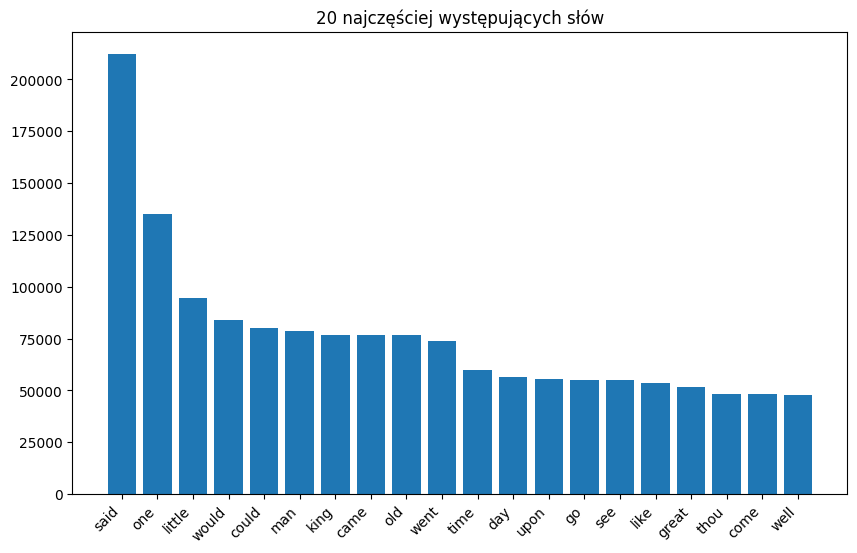

In [ ]:
all_words_b = [word for story in longest_FT for word in story['content'].split()]
word_counts_b = Counter(all_words_b)
top_words_b = word_counts_b.most_common(20)

words, counts = zip(*top_words_b)
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('20 najczęściej występujących słów')
plt.show()

In [ ]:
bigram_freq_b = get_ngrams([story['content'] for story in longest_FT], n=2)

top_bigrams_b = sorted(bigram_freq_b.items(), key=lambda x: x[1], reverse=True)[:15]
print("Top 15 bigramów:")
for bigram, count in top_bigrams_b:
    print(f"{bigram}: {count}")

Top 15 bigramów:
old man: 17072
old woman: 15756
young man: 10448
thou hast: 5610
said old: 4968
said king: 4950
thou art: 4425
kings son: 4386
long time: 4251
little girl: 3933
said little: 3852
thou wilt: 3180
went away: 3124
little boy: 2964
kings daughter: 2849


#### Interpretacja
##### Motywy w najdłuższych bajkach:
- W najdłuższych bajkach najczęściej występujące słowa oraz bigramy wskazują na bogatszą fabułę i większą liczbę interakcji między postaciami.
- Bigramy takie jak „old man” (17,072) i „old woman” (15,756) sugerują, że starsze postacie pełnią centralną rolę w tych opowieściach, pełniąc funkcję mędrców i przewodników.
- Ponadto, „young man” (10,448) i „little girl” (3,933) wskazują na obecność młodszych bohaterów, którzy przeżywają swoje przygody.
- Archaiczne zwroty, takie jak „thou hast” (5,610) i „thou art” (4,425), wskazują na klasyczny, magiczny charakter tych bajek, z elementami mitologicznymi lub historycznymi.
- Częste występowanie „said king” (4,950) i „kings son” (4,386) pokazuje, że motyw władzy i dziedziczenia jest również kluczowy w tych opowieściach.

#### PORÓWNANIE
- Bigramy jak „said king” w bajkach krótkich i długich wskazują, że motywy władzy i roli króla są centralne, ale ich częstotliwość w długich bajkach sugeruje, że są one bardziej rozwinięte w tych opowieściach, a postacie takie jak „kings daughter” i „little girl” dodają różnorodności.
- W najkrótszych bajkach częstymi postaciami są archetypowi bohaterowie, jak „old man” (720) oraz „kings son” (698), które sugerują mądrość oraz dziedziczenie władzy. Postacie te są często bardziej stereotypowe i pełnią klasyczne role.
- W najdłuższych bajkach również pojawiają się „old man” (17,072) i „kings son” (4,386), ale równocześnie mamy większą różnorodność postaci, w tym młodsze postacie jak „young man” (10,448) oraz „little girl” (3,933), co wskazuje na bardziej zróżnicowaną fabułę. Ponadto, pojawiają się formy archaiczne jak „thou hast” (5,610), które podkreślają historyczny lub mitologiczny kontekst.

- Porównanie wniosków z analizy najkrótszych i najdłuższych bajek z interpretacją całego zbioru ujawnia spójność w kwestiach dotyczących archetypów postaci, roli dialogów, motywów fabularnych oraz języka. W krótkich bajkach narracja jest prostsza, z mniejszym naciskiem na rozbudowane dialogi czy archaizmy, podczas gdy w długich bajkach te elementy są bardziej rozwinięte. W obu przypadkach obserwujemy dominację klasycznych postaci, podróży bohaterów i przekazywania mądrości, co odzwierciedla ogólne motywy literackie w bajkach.

### Analiza TF-IDF

Top 20 słów na podstawie TF-IDF:
said        93.800498
little      37.175955
came        35.637847
king        35.338490
old         34.545573
man         34.528542
went        32.909565
time        26.640641
day         25.157257
like        24.999288
great       24.525305
thou        21.609058
come        21.321400
saw         21.002520
away        20.567858
took        19.144189
good        19.068485
long        18.691130
shall       17.443450
princess    17.338158
dtype: float64


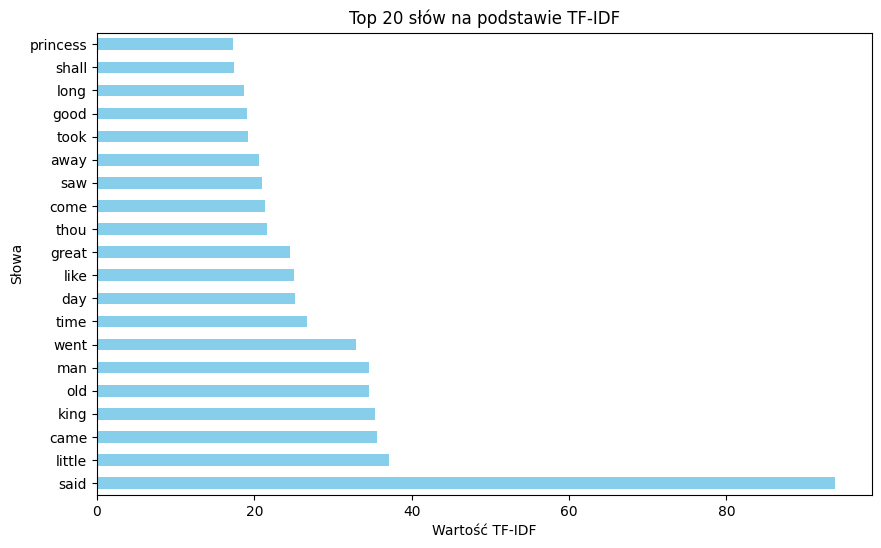

In [ ]:
docs = [' '.join(doc['content'].split()) for doc in CL_data]
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(docs)
tfidf_scores = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

top_tfidf_words = tfidf_scores.sum(axis=0).sort_values(ascending=False).head(20)
print("Top 20 słów na podstawie TF-IDF:")
print(top_tfidf_words)

top_tfidf_words.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 20 słów na podstawie TF-IDF')
plt.xlabel('Wartość TF-IDF')
plt.ylabel('Słowa')
plt.show()

#### Interpretacja:

Wyniki analizy TF-IDF wskazują, że teksty zawierają wiele słów związanych z klasycznymi motywami bajkowymi, takimi jak postacie królewskie (np. "king", "princess") oraz akcje bohaterów (np. "said", "came", "went"). Często występujące słowa, takie jak "little", "good", "long", podkreślają prostotę języka i emocje w narracji. Elementy narracyjne, takie jak "time", "took", "shall", sugerują, że historie koncentrują się na upływającym czasie i decyzjach bohaterów. Wysokie wartości TF-IDF dla słów takich jak "saw" wskazują na ważność obserwacji i interakcji postaci w fabule.

### 3. Analiza sentymentu:
- Rozkład sentymentu
- Pozytywne/negatywne zakończenia
- Porównanie różnych fragmentów (np. początek, kulminacja, zakończenie).

##### Rozkład sentymentu

In [ ]:
def sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

sentiments = [sentiment(story['content']) for story in CL_data]

polarities = [sentiment[0] for sentiment in sentiments]
subjectivities = [sentiment[1] for sentiment in sentiments]

for story, sentiment_values in zip(CL_data[:5], sentiments[:5]):
    print(f"Story: {story['title']}, Polarity: {sentiment_values[0]}, Subjectivity: {sentiment_values[1]}")

Story: A Lost Paradise, Polarity: 0.11259392314188271, Subjectivity: 0.49518657028225666
Story: The Cruel Crane Outwitted, Polarity: 0.11571131706631953, Subjectivity: 0.49461620756225083
Story: THE GOLDEN GOOSE, Polarity: 0.11576059813157209, Subjectivity: 0.4934013257362149
Story: LITTLE SNOW WHITE, Polarity: 0.1158548735312472, Subjectivity: 0.4944787917534847
Story: ELEVENTH EVENING, Polarity: 0.12020592092581023, Subjectivity: 0.4938780870627707


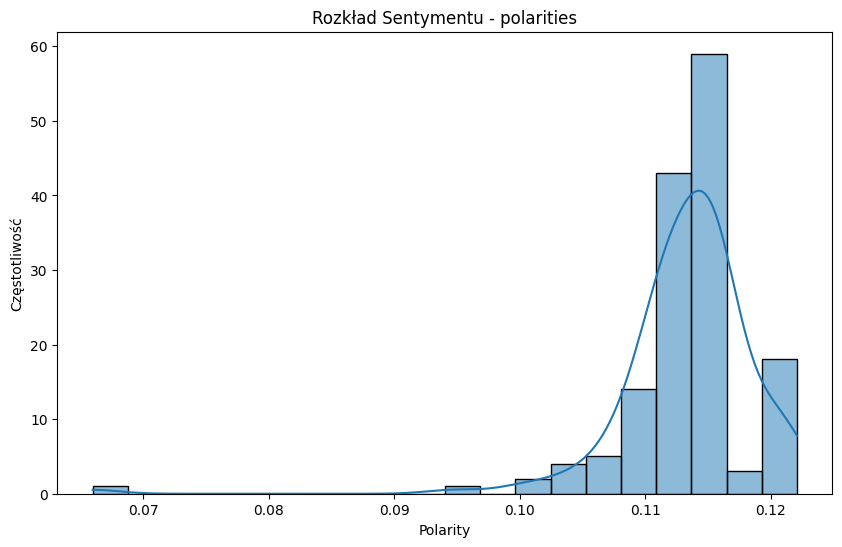

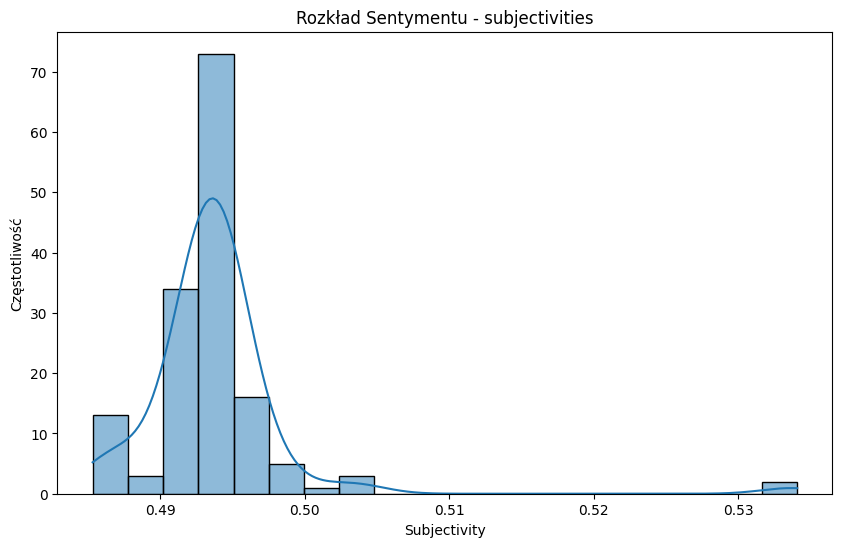

In [ ]:
polarities, subjectivities = zip(*sentiments)

# Wizualizacja sentymentu (Polarity)
plt.figure(figsize=(10,6))
sns.histplot(polarities, kde=True, bins=20)
plt.title("Rozkład Sentymentu - polarities")
plt.xlabel("Polarity")
plt.ylabel("Częstotliwość")
plt.show()

# Wizualizacja sentymentu (Subjectivity)
plt.figure(figsize=(10,6))
sns.histplot(subjectivities, kde=True, bins=20)
plt.title("Rozkład Sentymentu - subjectivities")
plt.xlabel("Subjectivity")
plt.ylabel("Częstotliwość")
plt.show()

##### Rozkład kategorii sentymentów

                                               Bajka  Polarity  Subjectivity  \
0  {'title': 'A Lost Paradise', 'content': 'lost ...  0.112594      0.495187   
1  {'title': 'The Cruel Crane Outwitted', 'conten...  0.115711      0.494616   
2  {'title': 'THE GOLDEN GOOSE', 'content': 'gold...  0.115761      0.493401   
3  {'title': 'LITTLE SNOW WHITE', 'content': 'lit...  0.115855      0.494479   
4  {'title': 'ELEVENTH EVENING', 'content': 'elev...  0.120206      0.493878   

   Sentiment  
0  Pozytywne  
1  Pozytywne  
2  Pozytywne  
3  Pozytywne  
4  Pozytywne  

Liczba dokumentów w każdej kategorii sentymentu:
Sentiment
Pozytywne    128
Neutralne     22
Name: count, dtype: int64


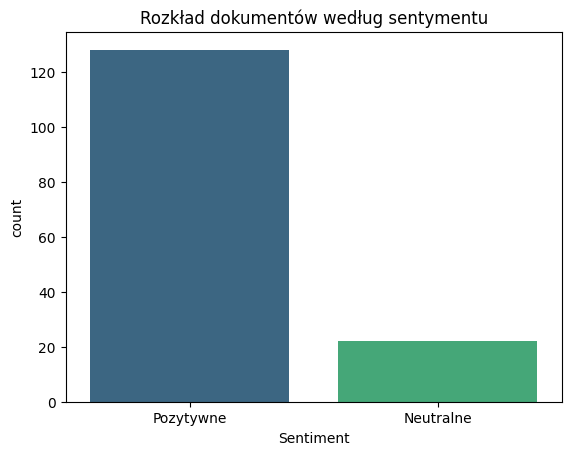

In [ ]:
def sentiment_category(polarity):
    if polarity > 0.11:
        return 'Pozytywne'
    elif polarity < -0.11:
        return 'Negatywne'
    else:
        return 'Neutralne'

sentiments = [sentiment_category(polarity) for polarity in polarities]

CL_data_with_sentiments = pd.DataFrame({
    'Bajka': CL_data[:len(sentiments)],
    'Polarity': polarities,
    'Subjectivity': subjectivities,
    'Sentyment': sentiments
})
print(CL_data_with_sentiments.head())

sentiment_counts = CL_data_with_sentiments['Sentyment'].value_counts()
print("\nLiczba dokumentów w każdej kategorii sentymentu:")
print(sentiment_counts)

sns.countplot(x='Sentyment', data=CL_data_with_sentiments, hue='Sentyment', palette='viridis', legend=False)
plt.title('Rozkład dokumentów według sentymentu')
plt.show()

In [ ]:
CL_data_with_sentiments_e = pd.DataFrame(CL_data_with_sentiments)
CL_data_with_sentiments_e.to_csv('CL_data_with_sentiments.csv', index=False, encoding='utf-8')

In [ ]:
CL_data_with_sentiments_e2 = pd.read_csv('CL_data_with_sentiments.csv', encoding='utf-8')
CL_data_with_sentiments = CL_data_with_sentiments_e2.to_dict(orient='records')

##### Średnia polarity i subjectivity dla całego zbioru

In [ ]:
average_polarity = sum(polarities) / len(polarities)
average_subjectivity = sum(subjectivities) / len(subjectivities)

print(f"Średnia Polarity: {average_polarity}")
print(f"Średnia Subjectivity: {average_subjectivity}")

Średnia Polarity: 0.11331703877048716
Średnia Subjectivity: 0.49381745628790535


##### Interpretacja wyników:
Polarity - czy tekst jest pozytywny, negatywny, czy neutralny?
- Rozkład oraz średnia polarity wynosząca 0.113, sugerują, że ogólny sentyment tekstów jest raczej neutralny, z tendencją w stronę pozytywnego

Subjectivity:
- Średnia subjectivity na poziomie 0.49 wskazuje, że teksty zawierają równie dużo personalnych opinii (1) co faktycznych informacji(0).

##### Czy bajki są ogólnie pozytywne, neutralne czy negatywne.

In [ ]:
positive_count = sentiments.count('Pozytywne')
neutral_count = sentiments.count('Neutralne')
negative_count = sentiments.count('Negatywne')

total_stories = len(CL_data)
positive_percentage = (positive_count / total_stories) * 100
neutral_percentage = (neutral_count / total_stories) * 100
negative_percentage = (negative_count / total_stories) * 100

In [ ]:
summary_data = {
    'Sentyment': ['Pozytywne', 'Neutralne', 'Negatywne'],
    'Ilość': [positive_count, neutral_count, negative_count],
    'Procent': [positive_percentage, neutral_percentage, negative_percentage]
}
summary_df = pd.DataFrame(summary_data)
print(summary_df)

   Sentyment  Ilość    Procent
0  Pozytywne    128  85.333333
1  Neutralne     22  14.666667
2  Negatywne      0   0.000000


In [ ]:
sorted_stories = sorted(zip(CL_data, sentiments), key=lambda x: x[1][0], reverse=True)

most_positive = sorted_stories[:5]
most_negative = sorted_stories[-5:]

print("Najbardziej pozytywne bajki:")
for story, sentiment_values in most_positive:
    print(f"Story: {story['title']}")

print("\nNajmniej pozytywne bajki:")
for story, sentiment_values in most_negative:
    print(f"Story: {story['title']}")

Najbardziej pozytywne bajki:
Story: A Lost Paradise
Story: The Cruel Crane Outwitted
Story: THE GOLDEN GOOSE
Story: LITTLE SNOW WHITE
Story: ELEVENTH EVENING

Najmniej pozytywne bajki:
Story: The Two Caskets
Story: Curdie Comes to Grief
Story: THE BOX OF ROBBERS
Story: JACK AND HIS MASTER
Story: GULEESH


##### Badanie, czy bajki mają pozytywne czy negatywne zakończenia

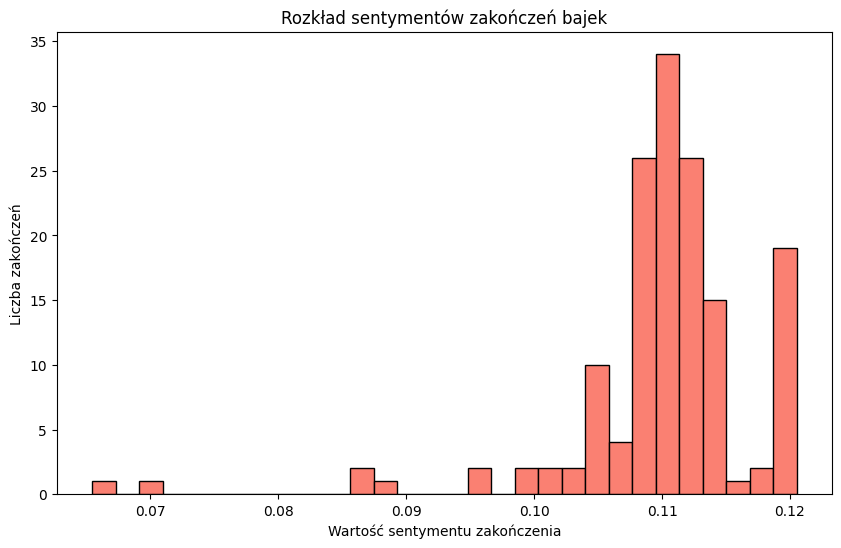

In [ ]:
def split_story(content, part='end'):
    n = len(content)
    if part == 'Początek':
        return content[:int(n * 0.33)]
    elif part == 'Kulminacja':
        return content[int(n * 0.33):int(n * 0.66)]
    elif part == 'Zakończenie':
        return content[int(n * 0.66):]

end_sentiments = []

for story in CL_data:
    ending = split_story(story['content'], 'Zakończenie')
    end_sentiments.append(sentiment(ending)[0])

plt.figure(figsize=(10, 6))
plt.hist(end_sentiments, bins=30, color='salmon', edgecolor='black')
plt.title('Rozkład sentymentów zakończeń bajek')
plt.xlabel('Wartość sentymentu zakończenia')
plt.ylabel('Liczba zakończeń')
plt.show()

##### Porównanie różnych fragmentów (np. początek, kulminacja, zakończenie).

In [ ]:
start_sentiments = []
middle_sentiments = []

for story in CL_data:
    start = split_story(story['content'], 'Początek')
    middle = split_story(story['content'], 'Kulminacja')
    start_sentiments.append(sentiment(start)[0])
    middle_sentiments.append(sentiment(middle)[0])

In [ ]:
start_avg = sum(start_sentiments) / len(start_sentiments)
middle_avg = sum(middle_sentiments) / len(middle_sentiments)
end_avg = sum(end_sentiments) / len(end_sentiments)

print(f"Średnia wartość sentymentu dla początku: {start_avg}")
print(f"Średnia wartość sentymentu dla kulminacji: {middle_avg}")
print(f"Średnia wartość sentymentu dla zakończenia: {end_avg}")

Średnia wartość sentymentu dla początku: 0.11487093468703369
Średnia wartość sentymentu dla kulminacji: 0.11689029785608172
Średnia wartość sentymentu dla zakończenia: 0.11012641971668524


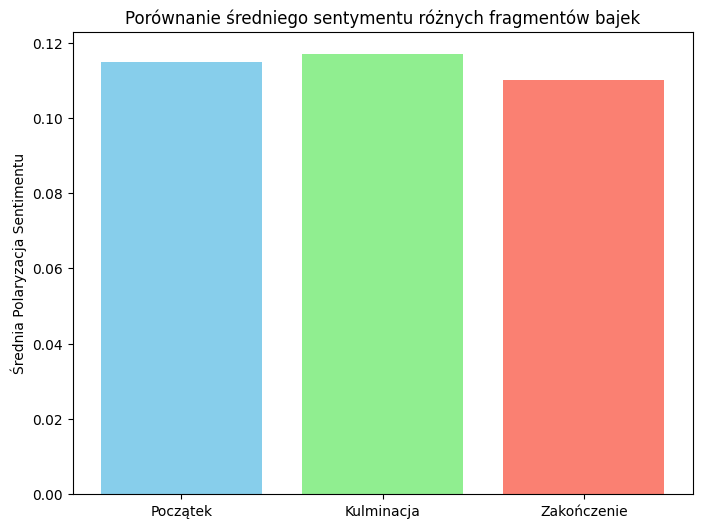

In [ ]:
labels = ['Początek', 'Kulminacja', 'Zakończenie']
avg_sentiments = [start_avg, middle_avg, end_avg]
plt.figure(figsize=(8, 6))
plt.bar(labels, avg_sentiments, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Porównanie średniego sentymentu różnych fragmentów bajek')
plt.ylabel('Średnia Polaryzacja Sentimentu')
plt.show()

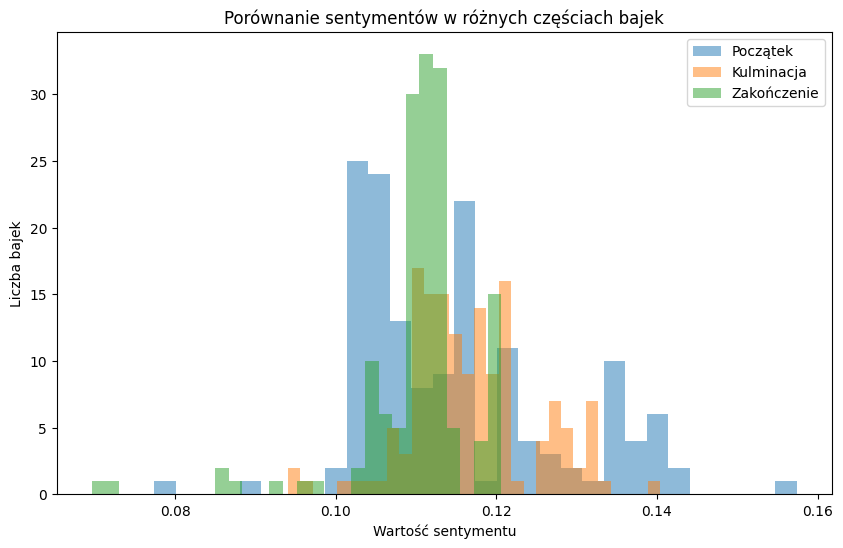

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(start_sentiments, bins=30, alpha=0.5, label='Początek')
plt.hist(middle_sentiments, bins=30, alpha=0.5, label='Kulminacja')
plt.hist(end_sentiments, bins=30, alpha=0.5, label='Zakończenie')
plt.legend()
plt.title('Porównanie sentymentów w różnych częściach bajek')
plt.xlabel('Wartość sentymentu')
plt.ylabel('Liczba bajek')
plt.show()

#### Interpretacja:

Bajki generalnie mają nautralny charakter z lekkim przychłem z stronę pozytywnych. Delikatnie niższą wartość sentymentu mają zakończenia bajek.

### 4. Analiza narracyjna:
- Ekstrakcja imion i nazw własnych
- Rozpoznanie archetypów postaci
- Analiza struktury bajek

In [ ]:
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
import nltk
nltk.download('maxent_ne_chunker_tab')

[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.


True

In [ ]:
print(f"Liczba wybranych bajek: {len(CL_data_4)}")

Liczba wybranych bajek: 150


In [ ]:
CL_data_P = pd.DataFrame(CL_data_4)
CL_data_P.to_csv('CL_data_4.csv', index=False, encoding='utf-8')

In [ ]:
CL_data_P = pd.read_csv('CL_data_4.csv', encoding='utf-8')
CL_data_4 = CL_data_P.to_dict(orient='records')

##### Ekstrakcja imion i nazw własnych

In [ ]:
def extract_character_names(text):
    names = re.findall(r'\b[A-ZŚŻŹŁĄĆĘÓŃ][a-zśżźłąćęóń]*\b', text)
    return names

In [ ]:
all_names = []

for story in CL_data_4:
    names = extract_character_names(story['content'])
    all_names.extend(names)

unique_names = list(set(all_names))

##### Named Entity Recognition, NER

In [ ]:
!pip install spacy

In [ ]:
!python3 -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 14.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_character_names(text):
    doc = nlp(text)
    names = []
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            names.append(ent.text)
    return names

In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2000000

In [ ]:
all_names_NER = []
for story in CL_data_4:
    content = story['content']
    names = extract_character_names(content)
    all_names_NER.extend(names)

unique_names_NER = list(set(all_names_NER))

#### Nie działa, za dużo danych i kernel nie daje rady ;)

##### Rozpoznanie archetypów postaci: bohater, złoczyńca, pomocnik, księżniczka.

In [ ]:
archetypes = {
    'Bohater': ['knights', 'knight', 'brave', 'good hero', 'hero', 'kings son', 'young man', 'little boy', 'little girl'],
    'Złoczyńca': ['sorcerer', 'villain', 'witch', 'evil', 'enemy', 'devil', 'troll', 'old man', 'old woman', 'giant'],
    'Pomocnik': ['companion', 'guide', 'friend', 'sidekick', 'helper', 'assistant', 'faithful servant', 'old lady', 'said king', 'said curdie', 'said irene'],
    'Księżniczka': ['kings daughter','princess', 'royal princess', 'maiden', 'queen',  'lady', 'damsel'],
    'Mędrzec': ['wizard', 'sage', 'master', 'guide', 'elder', 'mentor','teacher', 'guardian', 'advisor'],
    'Łobuz': ['fool', 'trickster', 'rogue', 'cheater', 'joker'],
    'Niewinny': ['child', 'innocent soul', 'victim', 'simple person'],
    'Władca': ['ruler', 'king', 'prince', 'queen', 'great leader', 'tyrant'],
    'Obrońca': ['knight', 'warrior', 'guard', 'protector'],
    'Towarzysz': ['companion', 'partner', 'sidekick', 'friend'],
    'Rzemieślnik': ['blacksmith', 'craftsman', 'builder', 'merchant', 'artisan', 'worker'],
    'Rodzic': ['father', 'mother', 'parent', 'guardian', 'caretaker', 'protector', 'nurturer'],
    'Dziecko': ['child', 'baby', 'young girl', 'young boy', 'infant', 'kid'],
    'Zwierzęta': ['fox', 'bear', 'wolf', 'bird', 'dog', 'cat', 'rabbit', 'horse', 'lion', 'eagle', 'deer']
}

In [ ]:
def assign_archetype(name):
    for archetype, keywords in archetypes.items():
        for keyword in keywords:
            if keyword in name.lower():
                return archetype
    return 'Nieznany'

In [ ]:
character_archetypes = []
for name in unique_names:
    archetype = assign_archetype(name)
    character_archetypes.append({
        'name': name,
        'archetype': archetype
    })

In [ ]:
data = {
    'Postać': [],
    'Archetyp': []
}
for character in character_archetypes:
    if character['archetype'] != 'Nieznany':
        data['Postać'].append(character['name'])
        data['Archetyp'].append(character['archetype'])

df_archetypes = pd.DataFrame(data)
print(df_archetypes.head(20))

           Postać   Archetyp
0       Babylonis    Dziecko
1   Schoolmasters    Mędrzec
2        Passages    Mędrzec
3       Kingscote    Bohater
4     Rothschilds   Niewinny
5            Kidr    Dziecko
6          Horses  Zwierzęta
7           Giant  Złoczyńca
8            Baby    Dziecko
9         Brogues      Łobuz
10           King    Bohater
11         Knight    Bohater
12        Looking    Bohater
13        Shaking    Bohater
14         Taking    Bohater
15     Catherines  Zwierzęta
16          Devil  Złoczyńca
17    Wonderchild   Niewinny
18   Winedrinking    Bohater
19        Friends   Pomocnik


In [ ]:
df_archetypes.to_csv('df_archetypes.csv', index=False, encoding='utf-8')

In [ ]:
arch = pd.read_csv('df_archetypes.csv', encoding='utf-8')
df_archetypes = arch.to_dict(orient='records')

In [ ]:
archetype_counts = df_archetypes['Archetyp'].value_counts()

In [ ]:
print("Liczba postaci według archetypów:")
for archetype, count in archetype_counts.items():
    print(f"{archetype}: {count}")

Liczba postaci według archetypów:
Zwierzęta: 69
Bohater: 58
Złoczyńca: 24
Mędrzec: 20
Księżniczka: 19
Rodzic: 16
Niewinny: 8
Łobuz: 8
Pomocnik: 8
Dziecko: 7
Obrońca: 5
Rzemieślnik: 2
Władca: 2


In [ ]:
df_archetypes_counts = pd.DataFrame(list(archetype_counts.items()), columns=['Archetyp', 'Liczba'])
df_archetypes_counts = df_archetypes_counts.sort_values(by='Liczba', ascending=False)
print(df_archetypes_counts)

       Archetyp  Liczba
13    Zwierzęta      69
0       Bohater      58
1     Złoczyńca      24
4       Mędrzec      20
3   Księżniczka      19
11       Rodzic      16
2      Pomocnik       8
5         Łobuz       8
6      Niewinny       8
12      Dziecko       7
8       Obrońca       5
7        Władca       2
10  Rzemieślnik       2
9     Towarzysz       0


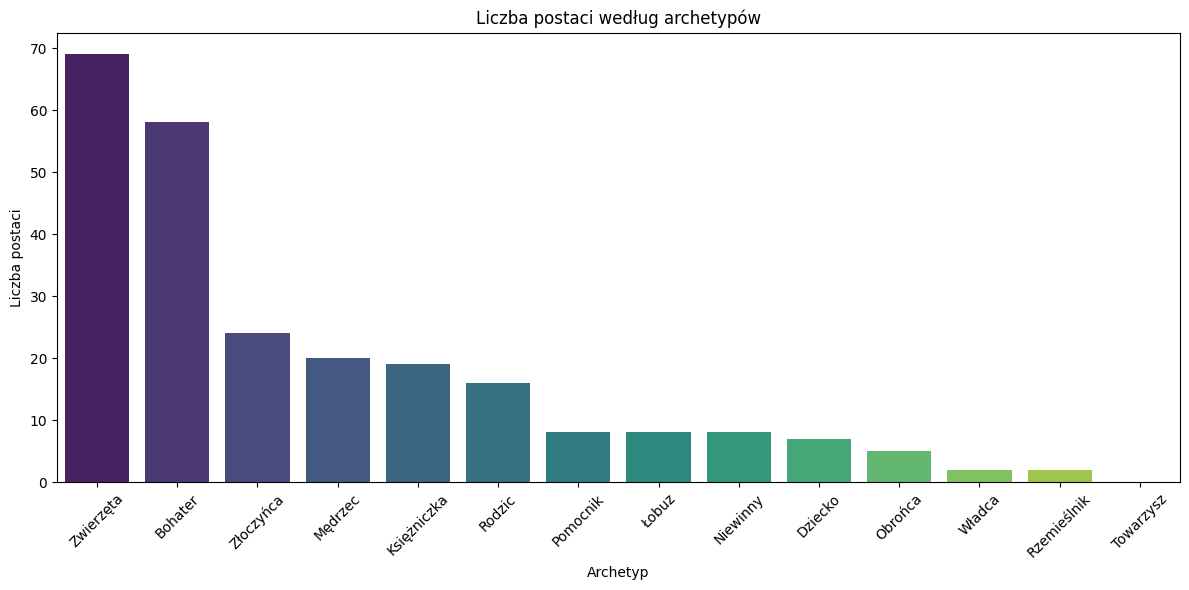

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Archetyp', y='Liczba', hue='Archetyp', data=df_archetypes_counts, palette='viridis', legend=False)
plt.title('Liczba postaci według archetypów')
plt.xlabel('Archetyp')
plt.ylabel('Liczba postaci')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### WNIOSKI

##### Najczęściej występujące archetypy:

- Bohater (58): Jest to najczęstszy archetyp w zbiorze bajek, co sugeruje, że bajki koncentrują się głównie na postaciach, które odgrywają centralną rolę w opowieściach, często jako postaci główne.
- Zwierzęta (69): Również występują bardzo często. Może to wskazywać na dominujący motyw postaci zwierzęcych w bajkach, które pełnią ważną rolę w wielu opowieściach, np. jako towarzysze bohaterów, czy nawet jako personifikowane postacie.


##### Rzadziej występujące archetypy:

- Władca (2): Tylko dwie bajki zawierają postacie w roli władcy. Może to sugerować, że ten archetyp jest mniej obecny w badanych bajkach, a motywy związane z władzą są mniej popularne lub bardziej subtelne.
- Towarzysz (0): Brak postaci typu "towarzysz" może wskazywać, że w analizowanych bajkach rzadziej występują postacie wspierające lub pomocnicze, które nie pełnią głównej roli w historii.
- Rzemieślnik (2): Postać rzemieślnika pojawia się tylko w dwóch bajkach, co może sugerować, że tego typu postacie nie są powszechnie wykorzystywane w tego rodzaju literaturze.

##### Archetypy związane z rolą moralną i społeczną:

- Złoczyńca (24), Mędrzec (20), Łobuz (8): Archetypy złoczyńcy i mędrca są również stosunkowo często spotykane, co może wskazywać na dominację klasycznych motywów walki dobra ze złem i naukowych postaci, które pełnią rolę przewodników lub mentorów.
- Rodzic (16), Dziecko (7), Niewinny (8): Archetypy związane z relacjami rodzinnymi, jak rodzic czy dziecko, są obecne, ale mniej liczne, co może wskazywać, że wiele bajek skupia się bardziej na przygodach niż na głębszych relacjach rodzinnych.

##### Rodzaj bajki:

- Obecność Księżniczki (19) i Zwierząt (69) może sugerować, że analizowane bajki mają częste motywy klasyczne, takie jak królewskie historie, baśnie o księżniczkach, oraz opowieści z silnym wpływem postaci zwierzęcych.

##### Brak równowagi:

- Widać wyraźnie, że wśród archetypów są duże dysproporcje. Niektóre postacie są częściej reprezentowane, co może wskazywać na powtarzalność pewnych motywów w zbiorze bajek.

#### Porównanie między bajkami: jakie archetypy dominują w poszczególnych bajkach, czy istnieją powtarzające się wzorce w zależności od autora lub tematyki.

In [ ]:
unique_names_in_story = set(extract_character_names(story['content']))
print(f"Bajka: {story['title']}, Unikalne postacie: {len(unique_names_in_story)}")

Bajka: STORY THE FIRST, Unikalne postacie: 5410


In [ ]:
def assign_story(story):
    return story['title']

In [ ]:
archetypes_in_stories = []

for story in CL_data_4:
    story_ch = assign_story(story)
    names = extract_character_names(story['content'])
    unique_names = set(names)

    for name in unique_names:
        archetype = assign_archetype(name)
        if archetype != 'Nieznany':
            archetypes_in_stories.append({
                'Nazwa': name,
                'Archetyp': archetype,
                'Bajka': story_ch
            })


In [ ]:
df_archetypes_in_stories = pd.DataFrame(archetypes_in_stories)
archetype_counts = df_archetypes_in_stories.groupby(['Bajka', 'Archetyp']).size().unstack(fill_value=0)
dominujace_archetypy = archetype_counts.idxmax(axis=1)

for bajka, archetyp in dominujace_archetypy.head(10).items():
    liczba = archetype_counts.loc[bajka, archetyp]
    print(f"Bajka: {bajka}, Dominujący archetyp: {archetyp}, Liczba postaci: {liczba}")

Bajka: A Fish Story, Dominujący archetyp: Zwierzęta, Liczba postaci: 63
Bajka: A LEGEND OF KNOCKMANY, Dominujący archetyp: Władca, Liczba postaci: 4
Bajka: ANDREW COFFEY, Dominujący archetyp: Władca, Liczba postaci: 1
Bajka: Adventures of Gilla na Chreck an Gour, Dominujący archetyp: Zwierzęta, Liczba postaci: 27
Bajka: Andras Baive, Dominujący archetyp: Zwierzęta, Liczba postaci: 28
Bajka: BUSHY BRIDE, Dominujący archetyp: Zwierzęta, Liczba postaci: 58
Bajka: Blue Beard, Dominujący archetyp: Zwierzęta, Liczba postaci: 37
Bajka: CONNLA AND THE FAIRY MAIDEN, Dominujący archetyp: Władca, Liczba postaci: 5
Bajka: DAPPLEGRIM, Dominujący archetyp: Zwierzęta, Liczba postaci: 61
Bajka: DRAKESTAIL, Dominujący archetyp: Zwierzęta, Liczba postaci: 61


In [ ]:
for bajka, counts in archetype_counts.head(10).iterrows():
    sorted_counts = counts.sort_values(ascending=False).head(3)
    archetypes = sorted_counts.index.tolist()
    liczby = sorted_counts.values.tolist()
    print(f"Bajka: {bajka}, Dominujący archetyp: {archetypes[0]}, Drugi archetyp: {archetypes[1]}, Trzeci archetyp: {archetypes[2]}, Liczba postaci: {liczby[0] + liczby[1] + liczby[2]}")

Bajka: A Fish Story, Dominujący archetyp: Zwierzęta, Drugi archetyp: Władca, Trzeci archetyp: Księżniczka, Liczba postaci: 126
Bajka: A LEGEND OF KNOCKMANY, Dominujący archetyp: Władca, Drugi archetyp: Mędrzec, Trzeci archetyp: Rodzic, Liczba postaci: 6
Bajka: ANDREW COFFEY, Dominujący archetyp: Władca, Drugi archetyp: Złoczyńca, Trzeci archetyp: Bohater, Liczba postaci: 2
Bajka: Adventures of Gilla na Chreck an Gour, Dominujący archetyp: Zwierzęta, Drugi archetyp: Władca, Trzeci archetyp: Księżniczka, Liczba postaci: 59
Bajka: Andras Baive, Dominujący archetyp: Zwierzęta, Drugi archetyp: Władca, Trzeci archetyp: Księżniczka, Liczba postaci: 60
Bajka: BUSHY BRIDE, Dominujący archetyp: Zwierzęta, Drugi archetyp: Władca, Trzeci archetyp: Księżniczka, Liczba postaci: 115
Bajka: Blue Beard, Dominujący archetyp: Zwierzęta, Drugi archetyp: Władca, Trzeci archetyp: Księżniczka, Liczba postaci: 72
Bajka: CONNLA AND THE FAIRY MAIDEN, Dominujący archetyp: Władca, Drugi archetyp: Zwierzęta, Trzec

In [ ]:
results = []

for bajka, counts in archetype_counts.head(10).iterrows():
    sorted_counts = counts.sort_values(ascending=False).head(3)
    archetypes = sorted_counts.index.tolist()
    liczby = sorted_counts.values.tolist()
    results.append({
        'Bajka': bajka,
        'Dominujący archetyp': archetypes[0],
        'Drugi archetyp': archetypes[1],
        'Trzeci archetyp': archetypes[2],
        'Liczba postaci': liczby[0] + liczby[1] + liczby[2]
    })

df_results = pd.DataFrame(results)
print(df_results)

                                   Bajka Dominujący archetyp Drugi archetyp  \
0                           A Fish Story           Zwierzęta         Władca   
1                  A LEGEND OF KNOCKMANY              Władca        Mędrzec   
2                          ANDREW COFFEY              Władca      Złoczyńca   
3  Adventures of Gilla na Chreck an Gour           Zwierzęta         Władca   
4                           Andras Baive           Zwierzęta         Władca   
5                            BUSHY BRIDE           Zwierzęta         Władca   
6                             Blue Beard           Zwierzęta         Władca   
7            CONNLA AND THE FAIRY MAIDEN              Władca      Zwierzęta   
8                             DAPPLEGRIM           Zwierzęta         Władca   
9                             DRAKESTAIL           Zwierzęta         Władca   

  Trzeci archetyp  Liczba postaci  
0     Księżniczka             126  
1          Rodzic               6  
2         Bohater     

##### Analiza relacji między postaciami, jak często pojawiają się razem i jakie są ich relacje.

In [ ]:
from collections import defaultdict

co_occurrence2 = defaultdict(lambda: defaultdict(int))

for story in CL_data_4:
    names = list(set(extract_character_names(story['content'])))

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            name1, name2 = names[i], names[j]
            co_occurrence2[name1][name2] += 1
            co_occurrence2[name2][name1] += 1

co_occurrence_df2 = pd.DataFrame(co_occurrence2)
print(co_occurrence_df2.head(10))

              Bragshaws  Crunch  Porters  Mostly  Haotsai  Wherever  Judeus  \
Crunch             26.0     NaN     28.0    28.0     28.0      28.0    28.0   
Porters            26.0    28.0      NaN    28.0     28.0      28.0    28.0   
Mostly             26.0    28.0     28.0     NaN     29.0      29.0    28.0   
Haotsai            26.0    28.0     28.0    29.0      NaN      29.0    28.0   
Wherever           26.0    28.0     28.0    29.0     29.0       NaN    28.0   
Judeus             26.0    28.0     28.0    28.0     28.0      28.0     NaN   
Herself            26.0    28.0     28.0    29.0     29.0      29.0    28.0   
Dinar              26.0    27.0     27.0    27.0     27.0      27.0    27.0   
Nashshar           26.0    27.0     27.0    27.0     27.0      27.0    27.0   
Twentyeighth       26.0    27.0     27.0    27.0     27.0      27.0    27.0   

              Herself  Dinar  Nashshar  ...  Gunnfjoder  Comber  Agrippinas  \
Crunch           28.0   27.0      27.0  ...        

In [ ]:
co_occurrence_df2.to_csv('co_occurrence_df2.csv', index=False, encoding='utf-8')


In [ ]:
co_occurrence_df = pd.read_csv('co_occurrence_df2.csv', encoding='utf-8')
co_occurrence = co_occurrence_df.to_dict(orient='records')

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_df2, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Macierz współwystępowania postaci")
plt.show()

NameError: name 'co_occurrence_df2' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
relationship_counts = defaultdict(lambda: defaultdict(int))
for story in CL_data_4:
    characters = all_names
    for i in range(len(characters)):
        for j in range(i + 1, len(characters)):
            char1 = characters[i]
            char2 = characters[j]
            relationship_counts[char1][char2] += 1
            relationship_counts[char2][char1] += 1

KeyboardInterrupt: 

In [ ]:
relationship_data = []

for name1, co_occurrence in co_occurrence.items():
    for name2, count in relations.items():
        relationship_data.append({'Postać 1': name1, 'Postać 2': name2, 'Liczba wspólnych wystąpień': count})
df_relationships = pd.DataFrame(relationship_data)
print(df_relationships)

In [ ]:
df_relationships_sorted = df_relationships.sort_values(by='Liczba wspólnych wystąpień', ascending=False)
print("\nPosortowane relacje:")
print(df_relationships_sorted)

In [ ]:
def build_cooccurrence_matrix(stories):
    cooccurrence = Counter()
    for story in stories:
        characters = all_names
        for i in range(len(characters)):
            for j in range(i + 1, len(characters)):
                char_pair = tuple(sorted([characters[i], characters[j]]))
                cooccurrence[char_pair] += 1
    return cooccurrence

In [ ]:
cooccurrence_matrix = build_cooccurrence_matrix(CL_data_4)
print(cooccurrence_matrix.most_common(10))

KeyboardInterrupt: 

In [ ]:
# Tworzenie grafu współwystępowania
G = nx.Graph()

for (char1, char2), count in cooccurrence_matrix.items():
    if count > 1:
        G.add_edge(char1, char2, weight=count)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7)
plt.title("Wykres współwystępowania postaci w bajkach")
plt.show()

####  Interpretacja wyników
- Macierz współwystępowania pozwala zobaczyć, które postacie występują często razem. Można zauważyć, czy są grupy postaci, które mają częste interakcje.
- Wizualizacja sieci pokazuje, jak postacie są ze sobą połączone. Postacie, które pojawiają się razem w tej samej bajce, będą połączone krawędzią. Im grubsza krawędź, tym częstsze współwystępowanie.


- Jakie postacie są najczęściej związane z centralnymi postaciami?
- Czy istnieją postacie, które rzadko występują w parze, ale mają duże znaczenie w kontekście fabuły?

##### Analiza struktury bajek: wstęp (problem), rozwój akcji, rozwiązanie.

In [ ]:
def analyze_story_structure(text):
    intro_keywords = ['once upon a time', 'in a kingdom', 'long ago', 'there was a']
    conflict_keywords = ['battle', 'quest', 'journey', 'struggle', 'conflict', 'fight', 'enemy']
    resolution_keywords = ['happily ever after', 'finally', 'the end', 'and so']
    intro = [sentence for sentence in text.split('.') if any(keyword in sentence.lower() for keyword in intro_keywords)]
    conflict = [sentence for sentence in text.split('.') if any(keyword in sentence.lower() for keyword in conflict_keywords)]
    resolution = [sentence for sentence in text.split('.') if any(keyword in sentence.lower() for keyword in resolution_keywords)]

    return {
        'wstęp': ' '.join(intro),
        'rozwój akcji': ' '.join(conflict),
        'rozwiązanie': ' '.join(resolution)
    }

In [ ]:
first_story = CL_data[0]
structured_story = analyze_story_structure(first_story['content'])
for part, content in structured_story.items():
    print(f"{part.capitalize()}:\n{content}\n")

### 5. Grupowanie i Analiza tematyczna (Topic Modeling):
- Wydobycie głównych motywów w bajkach (np. dobro kontra zło, magia, przygoda, miłość) - użycie algorytmu grupowania (np. k-means, LDA) do wykrywania tematów w bajkach

##### Wydobycie głównych motywów w bajkach

##### TOPIC MODELING

In [ ]:
documents = [story['content'] for story in CL_data]

# Użycie CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=0.2, stop_words='english')
dtm = vectorizer.fit_transform(documents)

# Model LDA
lda = LatentDirichletAllocation(n_components=8, random_state=42)
lda.fit(dtm)

# Funkcja do wyświetlania tematów
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Temat {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[-no_top_words:][::-1]]))

no_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, no_top_words)


ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [ ]:
CL_data_texts = [doc['content'] for doc in CL_data]

vectorizer = CountVectorizer(
    max_df=0.95,       # Wykluczenie bardzo częstych słów
    min_df=4,          # Ustawienie minimalnej liczby dokumentów na 4
    stop_words='english',  # Angielskie stopwords
    max_features=5000  # Limit liczby cech
)
doc_term_matrix = vectorizer.fit_transform(CL_data_texts)

print(f"Kształt macierzy dokument-term: {doc_term_matrix.shape}")

ValueError: max_df corresponds to < documents than min_df

In [ ]:
lda_model = LatentDirichletAllocation(
    n_components=7,    # Liczba tematów (zmniejszona dla przykładu)
    random_state=42,   # Powtarzalność wyników
    learning_method='batch'
)
lda_model.fit(doc_term_matrix)

In [ ]:
def display_topics(model, feature_names, n_top_words=10):
    topics = []
    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(f"Temat {idx + 1}: {', '.join(top_features)}")
    return topics

feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda_model, feature_names)
for topic in topics:
    print(topic)

In [ ]:
doc_topic_distribution = lda_model.transform(doc_term_matrix)

plt.figure(figsize=(10, 6))
for topic_idx in range(lda_model.n_components):
    plt.hist(doc_topic_distribution[:, topic_idx], bins=50, alpha=0.6, label=f'Temat {topic_idx + 1}')
plt.xlabel('Udział w dokumencie')
plt.ylabel('Liczba dokumentów')
plt.title('Rozkład udziałów tematów w dokumentach')
plt.legend()
plt.show()

##### NAZWY TEMATÓW na podstawie słów kluczowych:

1. Temat 1: Opowieści o królu i jego dworze
2. Temat 2: Podróże i przemijanie
3. Temat 3: Świat natury i bogactwa, przygoda
4. Temat 4: Baśnie o królewiczu, królu i jego córce, relacje i dramaty
5. Temat 5: Dom, natura
6. Temat 6: Rodzinne relacje
7. Temat 7: Życie i śmierć, filozoficzne

##### Średni udział tematów w dokumentach

In [ ]:
doc_topic_distribution = lda_model.transform(doc_term_matrix)
plt.figure(figsize=(10, 6))
topic_contribution = np.mean(doc_topic_distribution, axis=0)

topic_names = [
    'T1: Opowieści o królu i jego dworze',
    'T2: Podróże i przemijanie',
    'T3: Świat natury i bogactwa, przygoda',
    'T4: Baśnie o rodzinie królewskiej, relacje i dramaty',
    'T5: Dom, natura',
    'T6: Rodzinne relacje',
    'T7: Życie i śmierć, filozoficzne'
]

plt.bar(range(lda_model.n_components), topic_contribution, alpha=0.7, color='b', tick_label=topic_names)
plt.xlabel('Tematy')
plt.ylabel('Średni udział w dokumentach')
plt.title('Średni udział tematów w dokumentach')
plt.xticks(rotation=45, ha='right')
plt.show()

##### Dominujące tematy w dokumentach

In [ ]:
CL_data_titles = [story['title'] for story in CL_data_4]
topic_assignments = doc_topic_distribution.argmax(axis=1)

CL_data_topics = pd.DataFrame({
    'Dokument': CL_data_titles,
    'Dominujący temat': [topic_names[i] for i in topic_assignments]
})

print(CL_data_topics.head(10))

##### Rozkład sentymentów w różnych tematach

In [ ]:
CL_data_with_sentiments['Dominujący temat'] = [topic_names[i] for i in topic_assignments]

In [ ]:
print(CL_data_with_sentiments.columns)

In [ ]:
sentiment_per_topic = CL_data_with_sentiments.groupby(['Dominujący temat', 'Sentiment']).size().unstack().fillna(0)
sentiment_per_topic.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'gray', 'red'])
plt.title('Rozkład sentymentów w różnych tematach')
plt.xlabel('Temat')
plt.ylabel('Liczba bajek)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
CL_data_text.to_csv('CL_data_text.csv', index=False)
CL_data_topics.to_csv('CL_data_topics.csv', index=False)

In [ ]:
CL_data_with_sentiments['Length'] = CL_data_with_sentiments['Bajka'].apply(len)

plt.figure(figsize=(10, 6))
for topic in topic_names:
    topic_data = CL_data_with_sentiments[CL_data_with_sentiments['Dominujący temat'] == topic]
    plt.scatter(topic_data['Length'], topic_data['Polarity'], label=topic, alpha=0.7)

plt.xlabel('Długość bajki')
plt.ylabel('Polaryzacja (sentyment)')
plt.title('Relacja długości bajki i sentymentu dla różnych tematów')
plt.legend()
plt.show()

In [ ]:
doc_topic_df = pd.DataFrame(doc_topic_distribution, columns=[f'Temat {i+1}' for i in range(lda_model.n_components)])
doc_topic_df['Sentiment'] = CL_data_with_sentiments['Sentiment']

sentiment_topic_avg = doc_topic_df.groupby('Sentiment').mean()
print(sentiment_topic_avg)

In [ ]:
sentiment_topic_avg.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')

plt.title('Średni udział tematów w bajkach w zależności od sentymentu')
plt.xlabel('Sentyment')
plt.ylabel('Średni udział w bajkach')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Temat', labels=[f'Temat {i+1}' for i in range(lda_model.n_components)])
plt.show()

##### Średni sentyment w zależności od tematu

In [ ]:
sentiment_by_topic = CL_data_with_sentiments.groupby('Dominujący temat')['Polarity'].mean()

sentiment_by_topic.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Średni sentyment w zależności od tematu')
plt.xlabel('Temat')
plt.ylabel('Średni sentyment')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Porównanie stylu pisania między bajkami:
- Analiza długości zdań, różnorodności słownictwa i stylu między różnymi autorami (bajkami)
- Grupowanie na zbiody bajek wg autora na podstawie stylu pisania

#### Analiza długości zdań, różnorodności słownictwa i stylu między różnymi autorami (bajkami)

In [ ]:
def sentence_length(story):
    sentences = nltk.sent_tokenize(story['content'])
    return sum(len(nltk.word_tokenize(sentence)) for sentence in sentences) / len(sentences)

avg_sentence_lengths = [sentence_length(story) for story in CL_data]

In [ ]:
def ttr(story):
    words = nltk.word_tokenize(story['content'])
    unique_words = set(words)
    return len(unique_words) / len(words)

ttr_values = [ttr(story) for story in CL_data]

In [ ]:
def pos_tagging(story):
    words = nltk.word_tokenize(story['content'])
    tagged = nltk.pos_tag(words)
    return tagged

pos_tags = [pos_tagging(story) for story in CL_data]

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigrams = vectorizer.fit_transform([story['content'] for story in CL_data])

In [ ]:
sentence_lengths_avg = [sum(len(sentence.split()) for sentence in story['content'].split('.')) / len(story['content'].split('.')) for story in CL_data_4]
unique_words_avg = unique_word_counts

authors_comparison_df = pd.DataFrame({
    'Title': [story['title'] for story in CL_data_4],
    'Avg Sentence Length': sentence_lengths_avg,
    'Avg Unique Words': unique_words_avg
})

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Avg Sentence Length', y='Avg Unique Words', data=authors_comparison_df, hue='Title', palette='Set1')
plt.title('Porównanie stylu pisania bajek')
plt.xlabel('Średnia długość zdania (słów)')
plt.ylabel('Średnia liczba unikalnych słów')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sentiment', y='Avg Sentence Length', data=authors_comparison_df)
plt.title('Porównanie długości zdań według sentymentu')
plt.show()

In [ ]:
# Obliczanie korelacji między zmiennymi
correlation = authors_comparison_df[['Avg Sentence Length', 'Avg Unique Words']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Korelacja między długością zdań a różnorodnością słownictwa')
plt.show()

#### Grupowanie na zbiory bajek wg autora na podstawie stylu pisania

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Załóżmy, że mamy DataFrame z danymi o bajkach i metrykach
authors_comparison_df = pd.DataFrame({
    'Title': [story['title'] for story in CL_data_4],
    'Avg Sentence Length': sentence_lengths_avg,
    'Avg Unique Words': unique_words_avg,
    'Sentiment': [story['sentiment'] for story in CL_data_4]
})

# Standardyzacja danych, ponieważ różne cechy mogą mieć różną skalę
scaler = StandardScaler()
scaled_data = scaler.fit_transform(authors_comparison_df[['Avg Sentence Length', 'Avg Unique Words']])

# Można także dodać inne cechy, jak np. sentyment, w zależności od potrzeb


In [ ]:
# KMeans - wybór liczby grup (k)
kmeans = KMeans(n_clusters=3, random_state=42)  # Liczba grup zależy od tego, ile chcesz stworzyć
authors_comparison_df['Cluster'] = kmeans.fit_predict(scaled_data)

# Sprawdzanie wyników
print(authors_comparison_df.head())


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA - redukcja wymiarowości
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Dodanie wyników PCA do DataFrame
authors_comparison_df['PCA1'] = pca_components[:, 0]
authors_comparison_df['PCA2'] = pca_components[:, 1]

# Wizualizacja grup
plt.figure(figsize=(10, 8))
plt.scatter(authors_comparison_df['PCA1'], authors_comparison_df['PCA2'], c=authors_comparison_df['Cluster'], cmap='viridis')
plt.title('Grupowanie bajek wg stylu pisania')
plt.xlabel('Komponent 1')
plt.ylabel('Komponent 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# Analiza cech w poszczególnych grupach
grouped = authors_comparison_df.groupby('Cluster').agg({
    'Avg Sentence Length': 'mean',
    'Avg Unique Words': 'mean',
    'Sentiment': 'mean'  # Jeśli chcesz uwzględnić sentyment
})

print(grouped)


### 6. Ewaluacja
- Predykcja, F1-score i confusion matrix.
- Porównanie train i test

In [ ]:
# Wektoryzacja tekstu
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform([story['content'] for story in CL_data])
X_test = vectorizer.transform([story['content'] for story in test_CL_data])

# Przygotowanie etykiet
y_train = [story['Sentyment'] for story in CL_data_with_sentiments[:len(CL_data)]]
y_test = [story['Sentyment'] for story in CL_data_with_sentiments[len(CL_data):]]

# Trening modelu Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność modelu: {accuracy}")

In [ ]:
# Przewidywanie sentymentu na podstawie TextBlob
y_pred_train = list(map(lambda x: textblob_sentiment(x), tqdm([story['content'] for story in CL_data])))
y_pred_test = list(map(lambda x: textblob_sentiment(x), tqdm([story['content'] for story in test_CL_data])))

# Zakładając, że masz już etykiety sentymentu dla zbioru treningowego i testowego
# Sprawdzamy dokładność na zbiorach treningowym i testowym
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Wyniki
print(f"Dokładność na zbiorze treningowym: {train_accuracy}")
print(f"Dokładność na zbiorze testowym: {test_accuracy}")


In [ ]:
# Macierz pomyłek
conf_matrix = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:")
print(conf_matrix)

# Raport klasyfikacji (precyzja, czułość, F1-score)
class_report = classification_report(y_test, y_pred)
print("\nRaport klasyfikacji:")
print(class_report)

In [ ]:
# Możesz dostosować parametry Naive Bayes, np. laplace smoothing (alpha)
model = MultinomialNB(alpha=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score

In [ ]:
# Funkcja do analizy sentymentu za pomocą TextBlob
def textblob_sentiment(text):
    analysis = TextBlob(text)
    # Polarity: Jeśli > 0 to pozytywne, < 0 to negatywne, =0 neutralne
    return 'positive' if analysis.sentiment.polarity > 0 else 'negative' if analysis.sentiment.polarity < 0 else 'neutral'

# Predykcja na zbiorze treningowym i testowym
y_pred_train = list(map(lambda x: textblob_sentiment(x), tqdm([story['content'] for story in CL_data])))
y_pred_test = list(map(lambda x: textblob_sentiment(x), tqdm([story['content'] for story in test_CL_data])))

# Dokładność
train_accuracy = accuracy_score([story['Sentyment'] for story in CL_data], y_pred_train)
test_accuracy = accuracy_score([story['Sentyment'] for story in test_CL_data], y_pred_test)

print(f"Dokładność na zbiorze treningowym (TextBlob): {train_accuracy}")
print(f"Dokładność na zbiorze testowym (TextBlob): {test_accuracy}")


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Inicjalizacja SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Funkcja do analizy sentymentu za pomocą VADER
def vader_sentiment(sent):
    ss = sid.polarity_scores(sent)
    return np.argmax(list(ss.values())[:-1])  # 0 = negative, 1 = neutral, 2 = positive

# Predykcja na zbiorze treningowym i testowym
y_pred_train_vader = list(map(lambda x: vader_sentiment(x), tqdm([story['content'] for story in CL_data])))
y_pred_test_vader = list(map(lambda x: vader_sentiment(x), tqdm([story['content'] for story in test_CL_data])))

# Zamiana numerów na etykiety sentymentu
y_pred_train_vader = ['negative' if i == 0 else 'neutral' if i == 1 else 'positive' for i in y_pred_train_vader]
y_pred_test_vader = ['negative' if i == 0 else 'neutral' if i == 1 else 'positive' for i in y_pred_test_vader]

# Dokładność
train_accuracy_vader = accuracy_score([story['Sentyment'] for story in CL_data], y_pred_train_vader)
test_accuracy_vader = accuracy_score([story['Sentyment'] for story in test_CL_data], y_pred_test_vader)

print(f"Dokładność na zbiorze treningowym (VADER): {train_accuracy_vader}")
print(f"Dokładność na zbiorze testowym (VADER): {test_accuracy_vader}")

# Wykres rozkładu sentymentów
y_pred = pd.Series(y_pred_test_vader)
y_pred.value_counts().plot(kind='bar')
plt.show()

Bag of Words (BoW) – Reprezentacja Binarna i Częstościowa

In [ ]:

# Reprezentacja binarna
count_vec_bin = CountVectorizer(binary=True)
X_train_bin = count_vec_bin.fit_transform([story['content'] for story in CL_data])
X_test_bin = count_vec_bin.transform([story['content'] for story in test_CL_data])

# Reprezentacja częstościowa
count_vec_freq = CountVectorizer(binary=False)
X_train_freq = count_vec_freq.fit_transform([story['content'] for story in CL_data])
X_test_freq = count_vec_freq.transform([story['content'] for story in test_CL_data])

# Wizualizacja
def bow_matrix_to_table(matrix, features):
    return pd.DataFrame(data=matrix.toarray(), columns=features)

# Reprezentacja binarna
print("Reprezentacja binarna:")
print(bow_matrix_to_table(X_train_bin, count_vec_bin.get_feature_names_out()).head())

# Reprezentacja częstościowa
print("Reprezentacja częstościowa:")
print(bow_matrix_to_table(X_train_freq, count_vec_freq.get_feature_names_out()).head())

N-gramy

In [ ]:
count_vec_ngram = CountVectorizer(ngram_range=(1, 3))
X_train_ngram = count_vec_ngram.fit_transform([story['content'] for story in CL_data])
X_test_ngram = count_vec_ngram.transform([story['content'] for story in test_CL_data])

# Wizualizacja n-gramów
print("Reprezentacja n-gramów (1-3):")
print(bow_matrix_to_table(X_train_ngram, count_vec_ngram.get_feature_names_out()).head())


TF-IDF

In [ ]:

# TF-IDF
tfidf = TfidfVectorizer(use_idf=True, norm='l2', smooth_idf=True)
X_train_tfidf = tfidf.fit_transform([story['content'] for story in CL_data])
X_test_tfidf = tfidf.transform([story['content'] for story in test_CL_data])

# Wizualizacja
print("Reprezentacja TF-IDF:")
print(bow_matrix_to_table(X_train_tfidf, tfidf.get_feature_names_out()).head())


Trenowanie modelu Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Trening modelu Naive Bayes
clf = MultinomialNB()
clf.fit(X_train_tfidf, [story['Sentyment'] for story in CL_data])

# Predykcja
y_train_pred = clf.predict(X_train_tfidf)
y_test_pred = clf.predict(X_test_tfidf)

# Dokładność
multiNB_train_score = accuracy_score([story['Sentyment'] for story in CL_data], y_train_pred)
multiNB_test_score = accuracy_score([story['Sentyment'] for story in test_CL_data], y_test_pred)

print(f"Naive Bayes - Dokładność na zbiorze treningowym: {multiNB_train_score}")
print(f"Naive Bayes - Dokładność na zbiorze testowym: {multiNB_test_score}")

# Raport klasyfikacji
print(classification_report([story['Sentyment'] for story in test_CL_data], y_test_pred))

# Macierz pomyłek
conf_matrix = confusion_matrix([story['Sentyment'] for story in test_CL_data], y_test_pred)
print(conf_matrix)


SVM

In [ ]:
# Wektoryzacja tekstu (TF-IDF) - jeśli dane są już podzielone, pomijamy train_test_split
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.transform([story['content'] for story in CL_data])  # Zbiór treningowy
X_test_tfidf = vectorizer.transform([story['content'] for story in test_CL_data])  # Zbiór testowy

# Przygotowanie etykiet sentymentu (z danych z etykietami sentymentów)
y_train = [story['Sentyment'] for story in CL_data_with_sentiments[:len(CL_data)]]
y_test = [story['Sentyment'] for story in CL_data_with_sentiments[len(CL_data):]]

# Trening modelu SVM
svm_model = SVC(kernel='linear')  # Możesz wybrać kernel: 'linear', 'poly', 'rbf', itp.
svm_model.fit(X_train_tfidf, y_train)

# Predykcja
y_pred = svm_model.predict(X_test_tfidf)

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność modelu SVM: {accuracy}")

# Szczegółowa ocena (raport klasyfikacji)
print(classification_report(y_test, y_pred, target_names=['Pozytywny', 'Neutralny', 'Negatywny']))

# Możesz również zwizualizować macierz pomyłek
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pozytywny', 'Neutralny', 'Negatywny'], yticklabels=['Pozytywny', 'Neutralny', 'Negatywny'])
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz Pomyłek - SVM')
plt.show()
